<a href="https://colab.research.google.com/github/vinceriot/ML_lab/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%90%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D1%8B_%D0%93%D0%BE%D0%BB%D0%B4%D0%BE%D0%B1%D0%B8%D0%BD%D0%94%D0%90_%D0%A4%D0%98%D0%A2_1_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

## Declare required dependencies

In [5]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

## Data ingestion

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/diabetes_012_health_indicators_BRFSS2015.csv')

## Data exploration

In [8]:
df.head(5)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [9]:
print(df.shape)
print(df.describe())

(253680, 22)
        Diabetes_012         HighBP       HighChol      CholCheck  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.296921       0.429001       0.424121       0.962670   
std         0.698160       0.494934       0.494210       0.189571   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       1.000000       1.000000       1.000000   
max         2.000000       1.000000       1.000000       1.000000   

                 BMI         Smoker         Stroke  HeartDiseaseorAttack  \
count  253680.000000  253680.000000  253680.000000         253680.000000   
mean       28.382364       0.443169       0.040571              0.094186   
std         6.608694       0.496761       0.197294              0.292087   
min        12.000000       0.000000       0.000000           

## Ести ли пропуски?

In [10]:
df.isnull().values.any()

False

## Class distribution ( 0 - non fraudulent, 1 - fraudulent)

In [11]:
df['Diabetes_012'].value_counts()

,count
Diabetes_012,
0.0,213703
2.0,35346
1.0,4631


<ipython-input-12-a5920ecd47a8>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Diabetes_012'], sort = True)


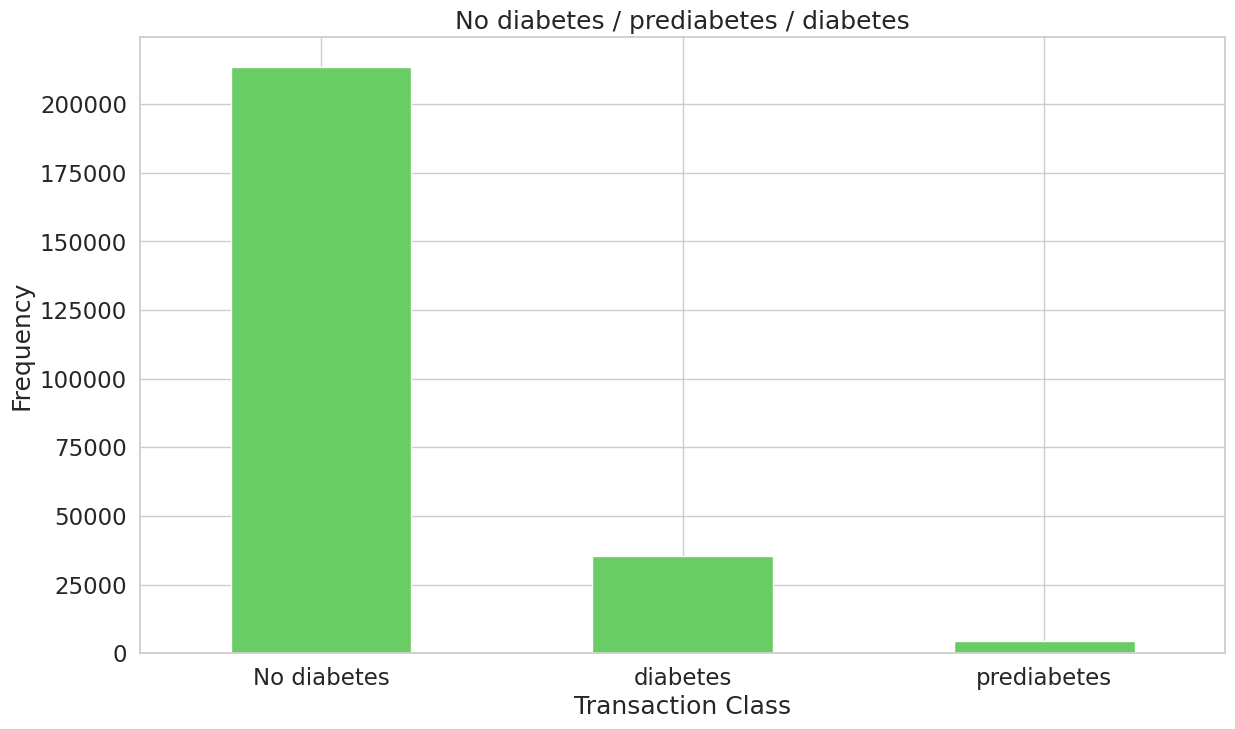

In [12]:
LABELS = ["No diabetes", "diabetes",  "prediabetes" ]
count_classes = pd.value_counts(df['Diabetes_012'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("No diabetes / prediabetes / diabetes")
plt.xticks(range(3), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency");

Наш набор данных очень сильно несбалансирован в пользу отрицательного (0, то есть нормального) класса. Это требует дальнейшего изучения данных

In [13]:
fraudsDF = df[df.Diabetes_012 == 0]
normalDF = df[df.Diabetes_012 == 2]
predDF = df[df.Diabetes_012 == 1]

In [14]:
fraudsDF.shape

(213703, 22)

In [15]:
normalDF.shape

(35346, 22)

In [16]:
predDF.shape

(4631, 22)

Давайте теперь посмотрим на сумму денег, задействованную в двух классах.

<Axes: >

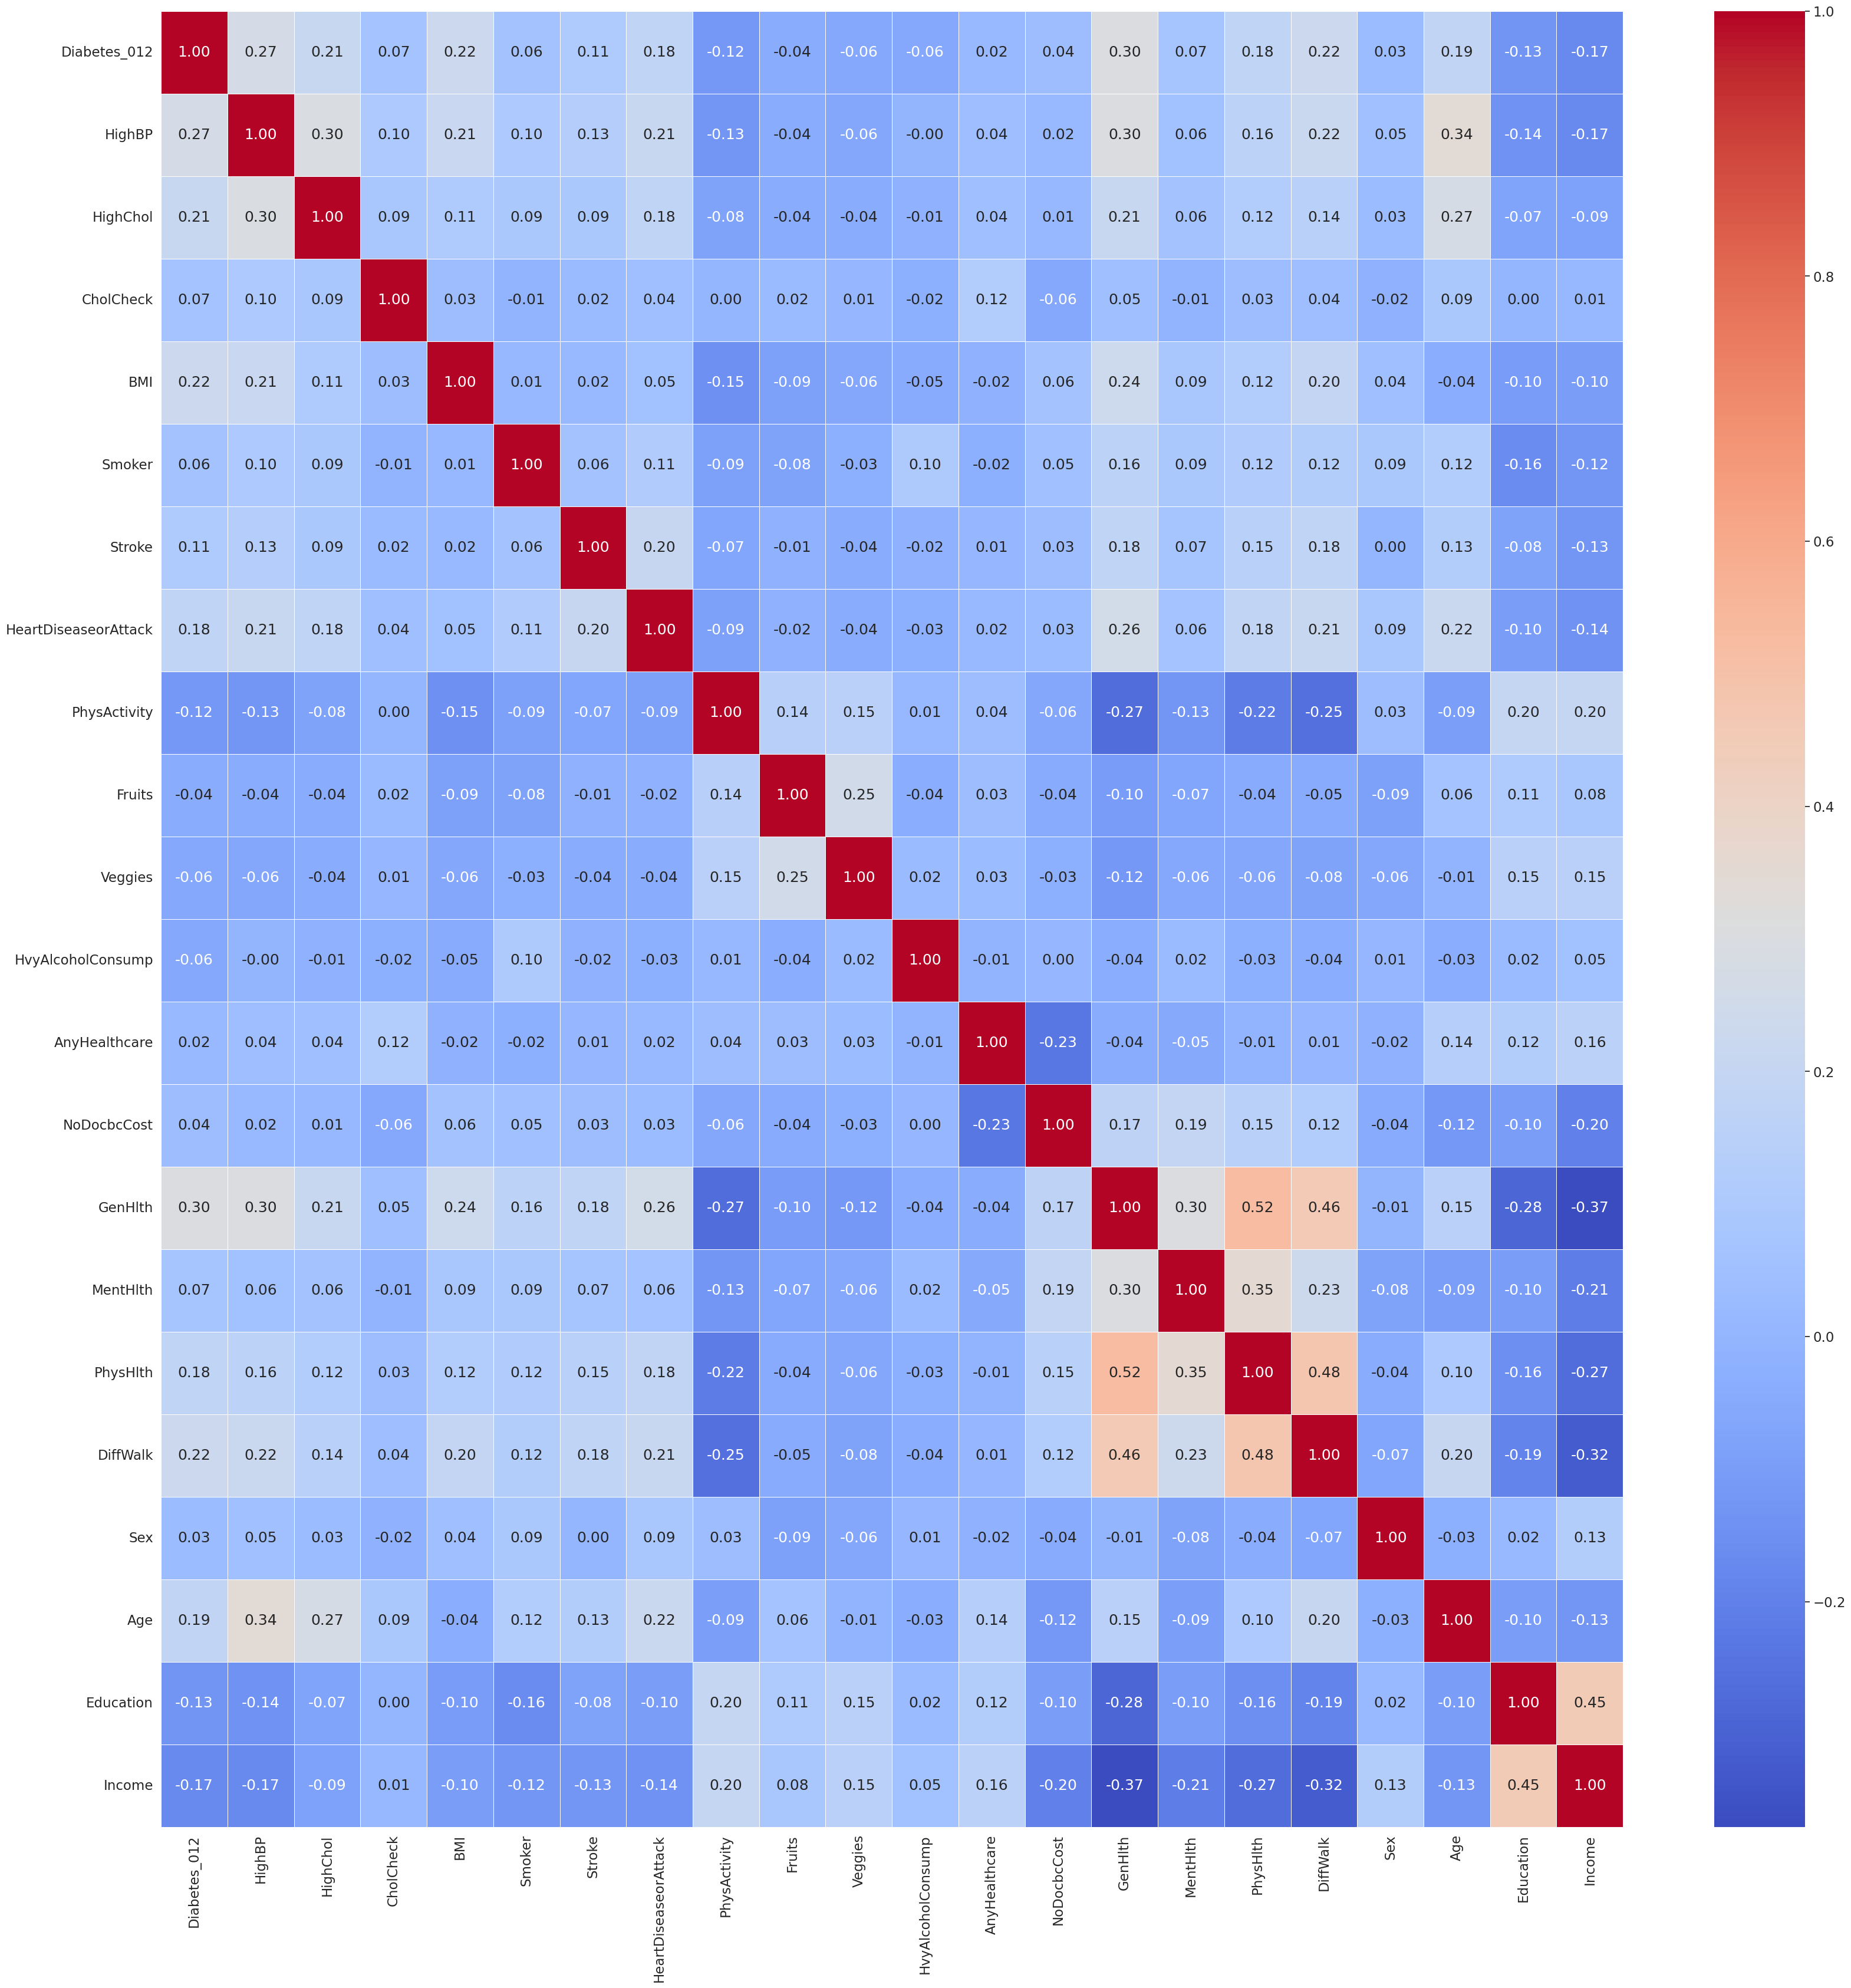

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr()

plt.figure(figsize=(40,40))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [18]:
# Выбираем корреляции для 'Diabetes_012'
Diabetes_012_corr = corr['Diabetes_012']

# Находим столбцы с корреляцией по модулю >= 0.07
relevant_columns = Diabetes_012_corr[abs(Diabetes_012_corr) >= 0.07].index

# Оставляем только эти столбцы в DataFrame
df = df[relevant_columns]

Graphically speaking ...`

In [19]:
df.shape

(253680, 14)

### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только строки без информации о сердечных ударах, а в тестовом наборе данных будут как случаи с сердечными ударами, так и без них.

In [20]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Diabetes_012 == 0]
X_train = X_train.drop(['Diabetes_012'], axis=1)

y_test = X_test['Diabetes_012']
X_test = X_test.drop(['Diabetes_012'], axis=1)

X_train = X_train.values

X_test = X_test.values
y_test = y_test.values
print(y_test.size)


50736


### Модель

In [21]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(13, 10),
            nn.Tanh(),
            nn.Linear(10, 5),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(5, 10),
           nn.Tanh(),
           nn.Linear(10, 13),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [22]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

In [23]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [24]:

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)


In [25]:
#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [27]:
history = {}
history['train_loss'] = []
history['test_loss'] = []


In [28]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/100], loss:22.2961
epoch [2/100], loss:5.2385
epoch [3/100], loss:1.3121
epoch [4/100], loss:0.7953
epoch [5/100], loss:0.6628
epoch [6/100], loss:0.4313
epoch [7/100], loss:0.3773
epoch [8/100], loss:0.3560
epoch [9/100], loss:0.3447
epoch [10/100], loss:0.3376
epoch [11/100], loss:0.3310
epoch [12/100], loss:0.3210
epoch [13/100], loss:0.3141
epoch [14/100], loss:0.3108
epoch [15/100], loss:0.3069
epoch [16/100], loss:0.3044
epoch [17/100], loss:0.3025
epoch [18/100], loss:0.3015
epoch [19/100], loss:0.2998
epoch [20/100], loss:0.2989
epoch [21/100], loss:0.2977
epoch [22/100], loss:0.2971
epoch [23/100], loss:0.2951
epoch [24/100], loss:0.2941
epoch [25/100], loss:0.2927
epoch [26/100], loss:0.2916
epoch [27/100], loss:0.2907
epoch [28/100], loss:0.2902
epoch [29/100], loss:0.2892
epoch [30/100], loss:0.2886
epoch [31/100], loss:0.2884
epoch [32/100], loss:0.2877
epoch [33/100], loss:0.2868
epoch [34/100], loss:0.2865
epoch [35/100], loss:0.2856
epoch [36/100], loss:0.2858


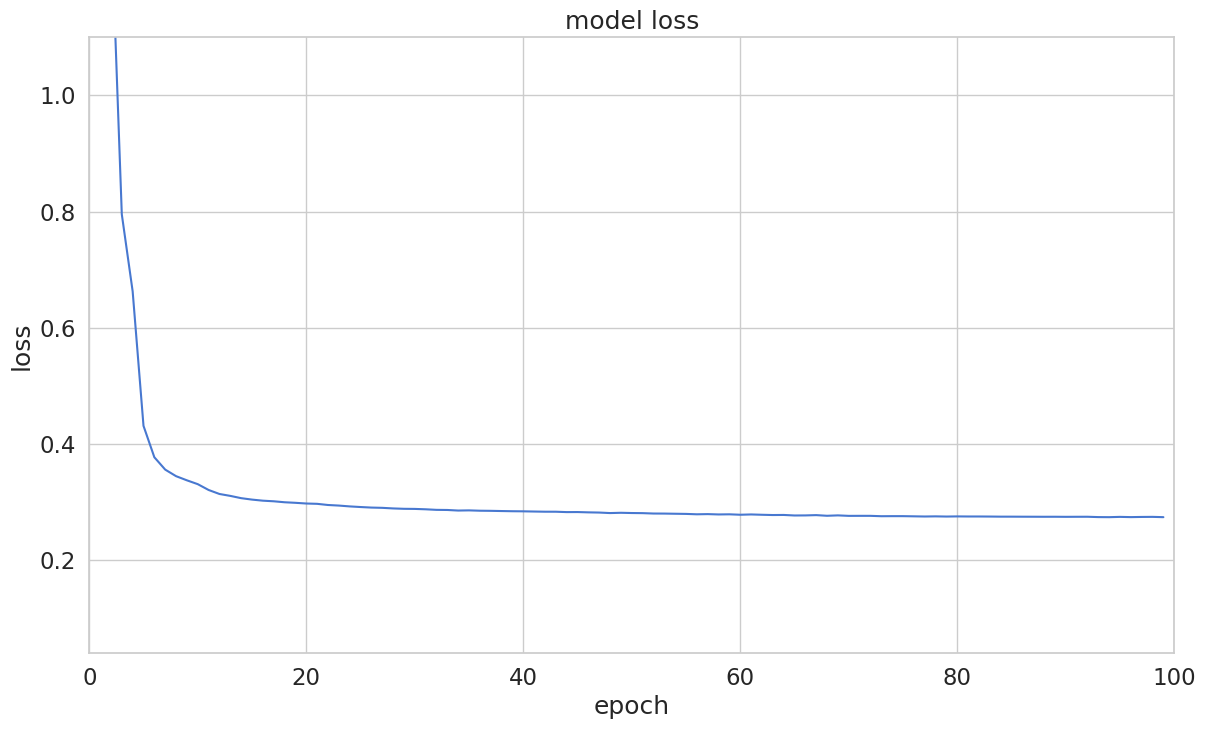

In [30]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.04,1.1])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Оценка модели

In [32]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Diabetes_012'] = y_test

In [33]:
reconstructionErrorDF.describe()

,pred_loss,Diabetes_012
count,50736.000000,50736.000000
mean,0.288652,0.294426
std,0.479015,0.695391
min,0.004103,0.000000
25%,0.092506,0.000000
50%,0.166724,0.000000
75%,0.301655,0.000000
max,27.301677,2.000000


# Reconstruction Errors without diabetes

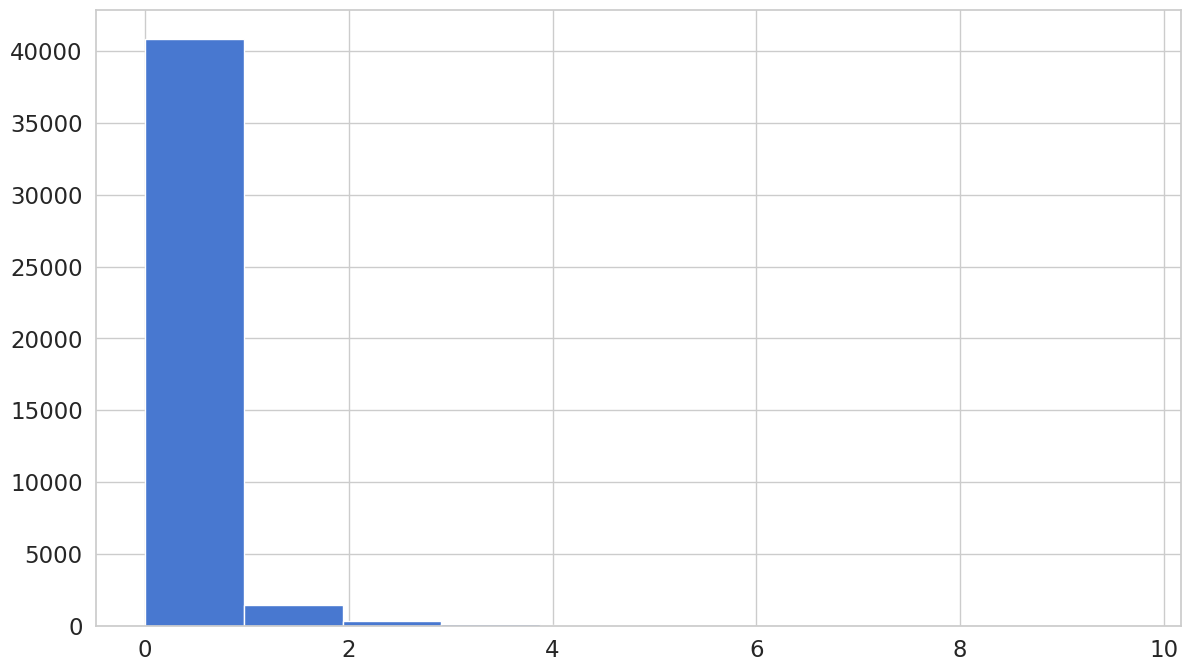

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Diabetes_012']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with prediabetes

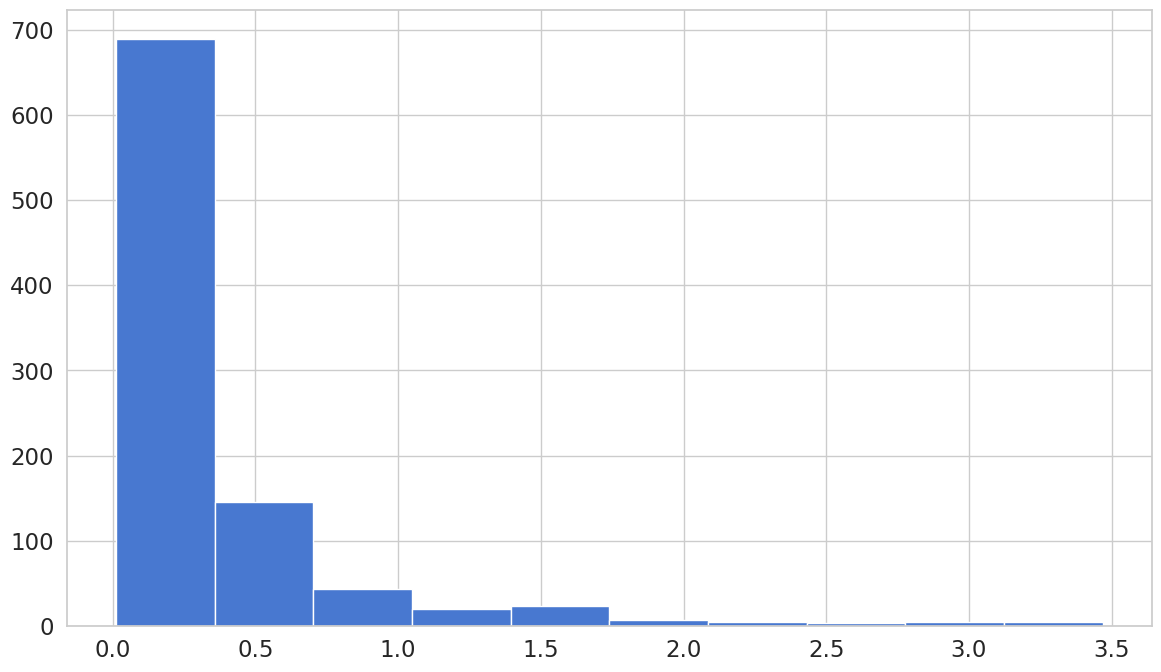

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Diabetes_012']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with diabetes

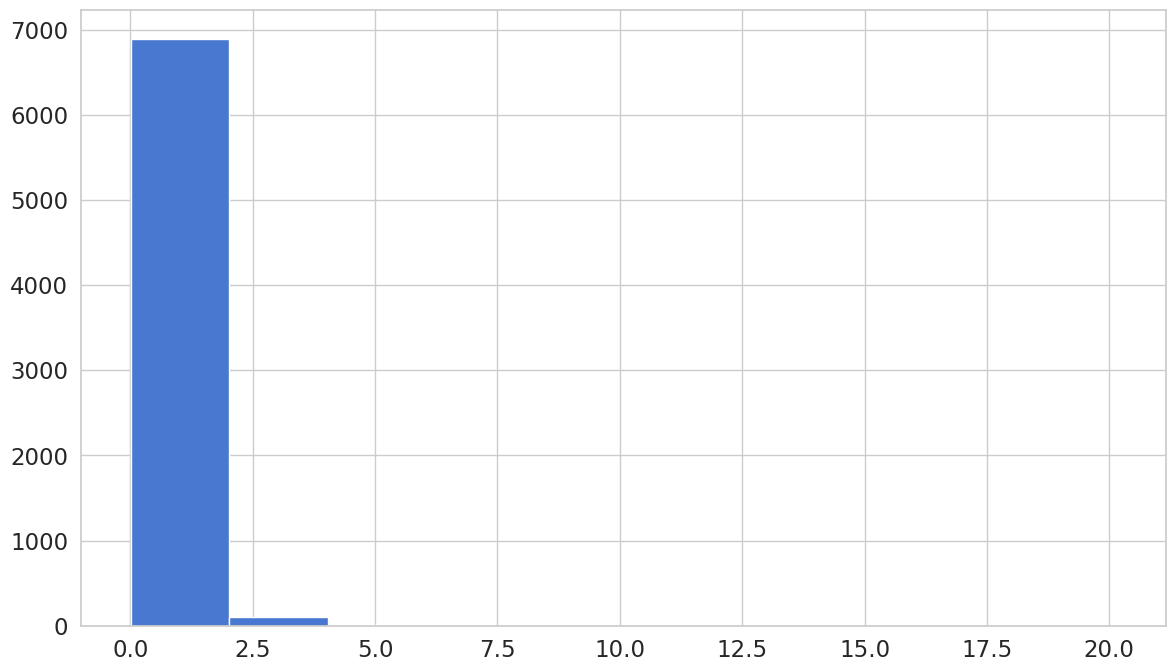

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Diabetes_012']== 2) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

In [48]:
# Оставляем только строки, где Diabetes_012 равно 0 или 2
filtered_df = reconstructionErrorDF[reconstructionErrorDF['Diabetes_012'].isin([0, 2])]
filtered_df['binary_labels'] = filtered_df['Diabetes_012'].apply(lambda x: 1 if x == 2 else 0)


<ipython-input-48-99d459201499>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binary_labels'] = filtered_df['Diabetes_012'].apply(lambda x: 1 if x == 2 else 0)


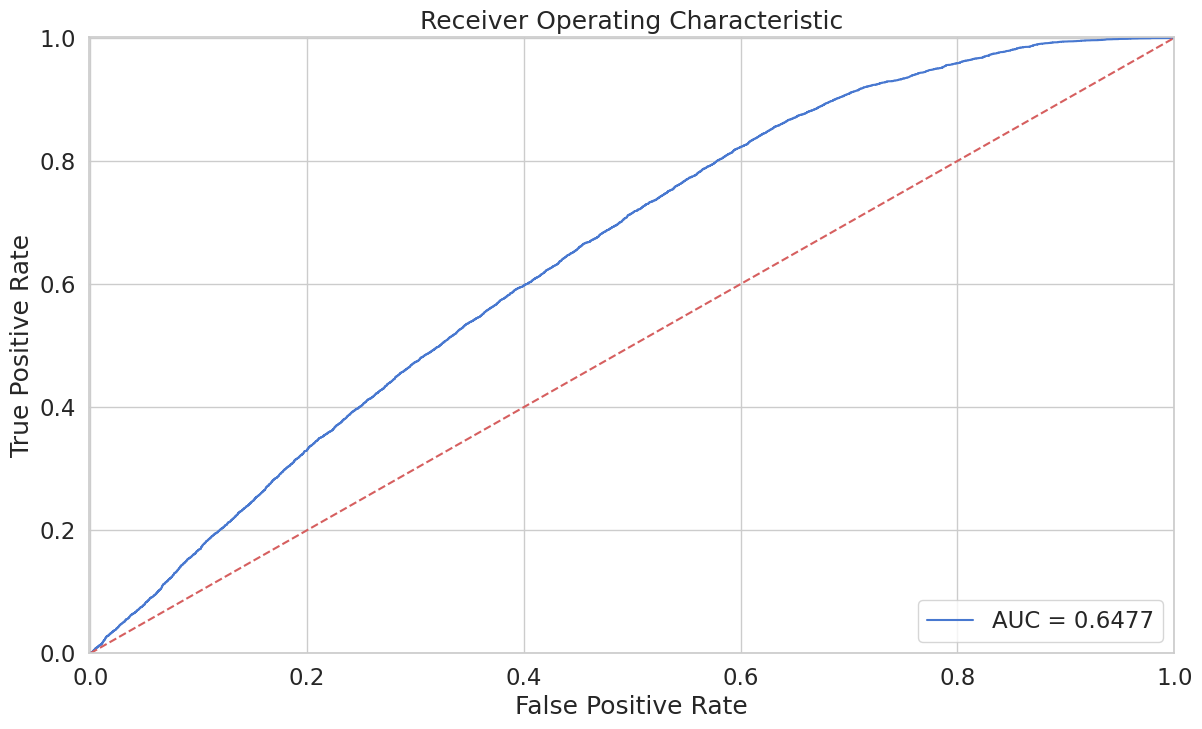

In [49]:
fpr, tpr, thresholds = roc_curve(filtered_df['binary_labels'], filtered_df['pred_loss'])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

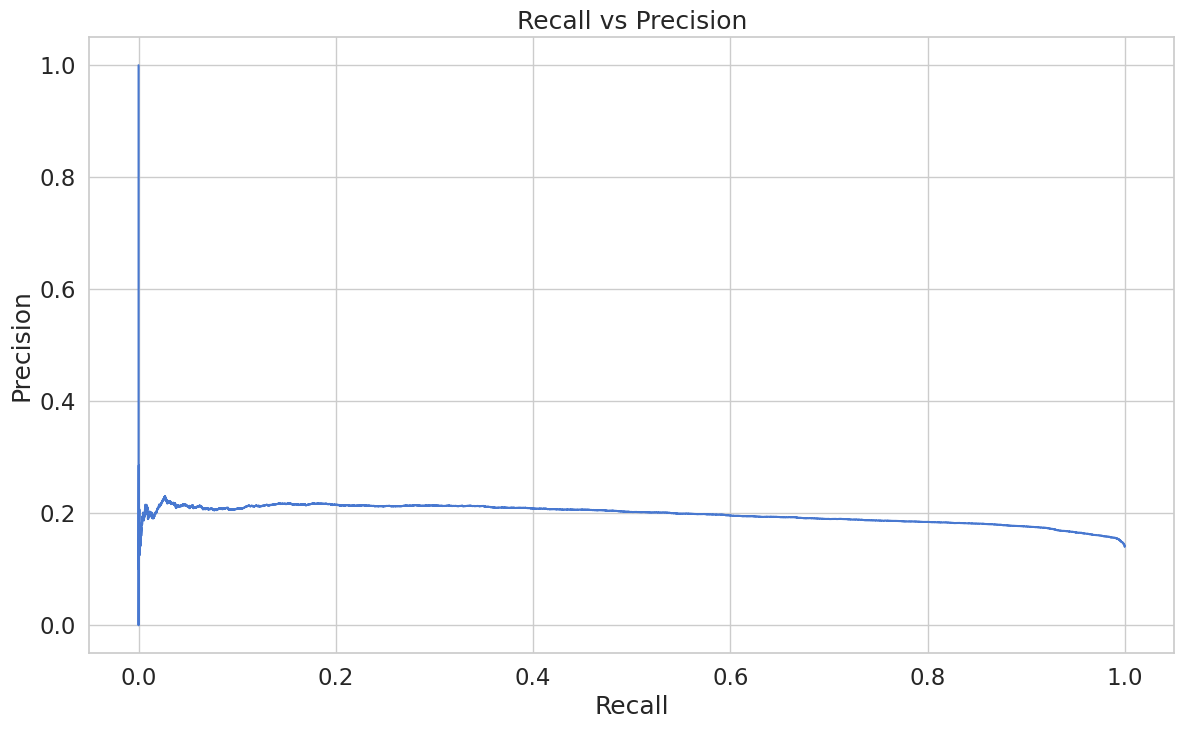

In [54]:
precision, recall, thresholds = precision_recall_curve(filtered_df['binary_labels'], filtered_df['pred_loss'])
# График Precision-Recall
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

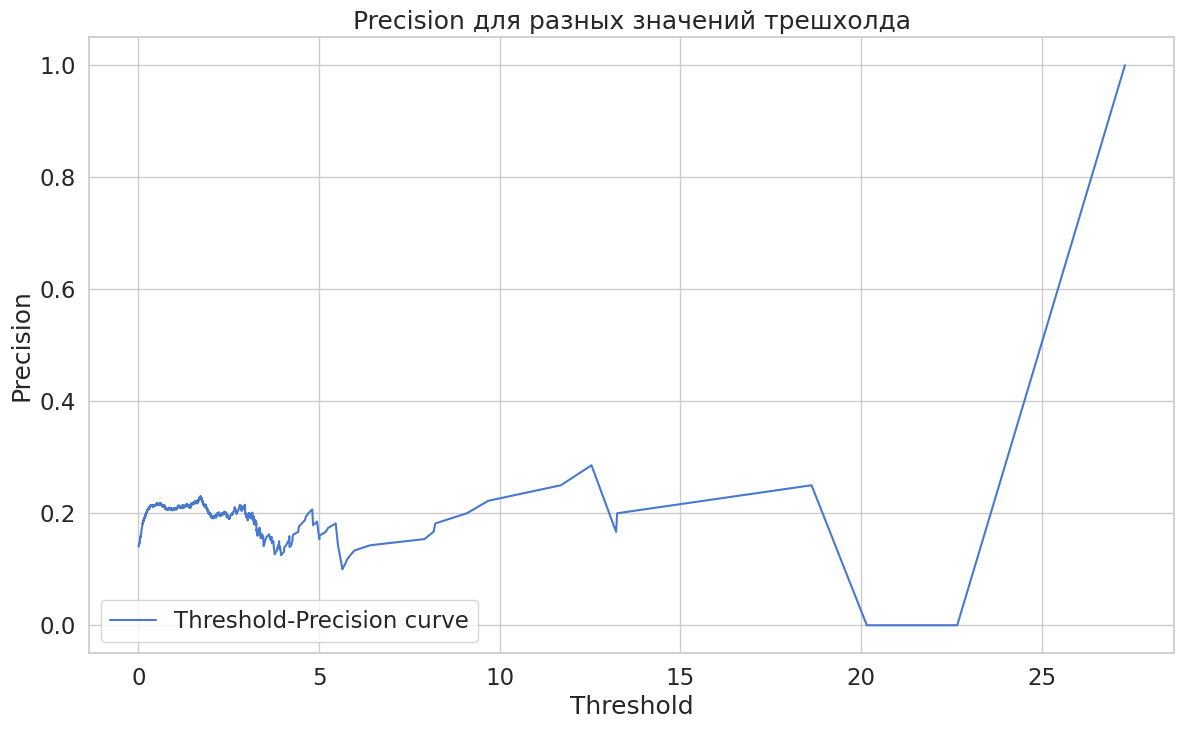

In [56]:
# График Precision для разных значений порога
plt.plot(thresholds, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


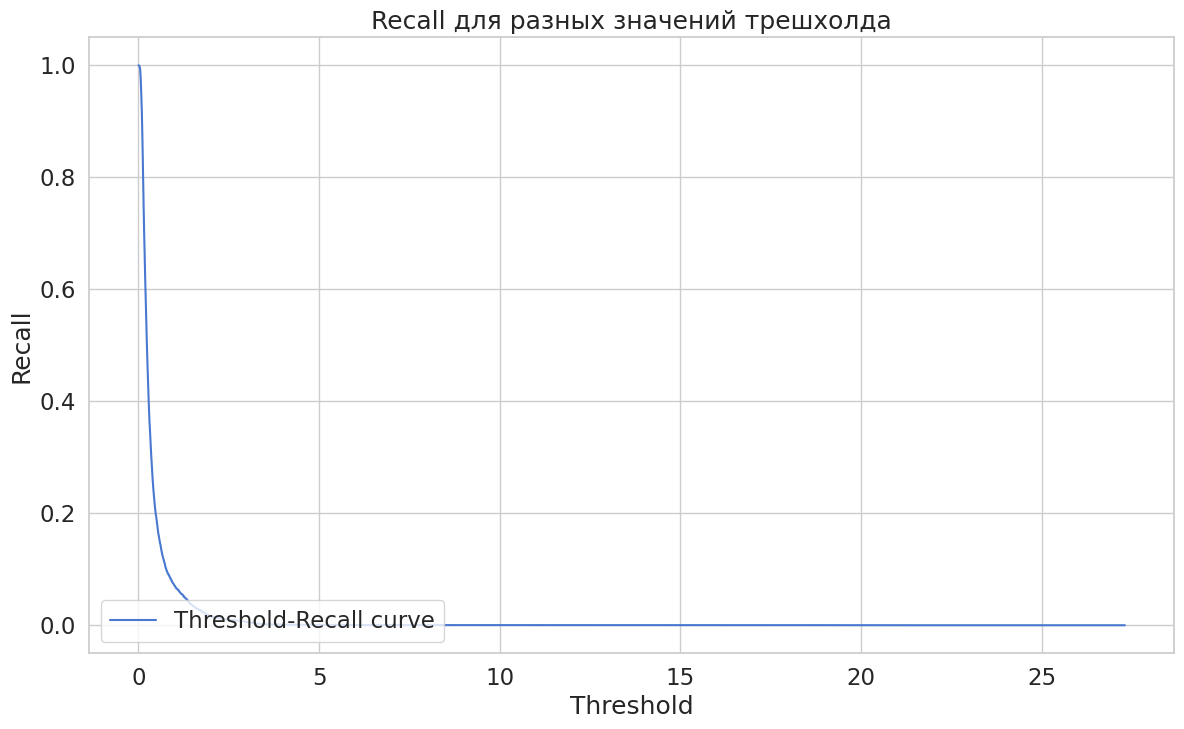

In [57]:
# График Recall для разных значений порога
plt.plot(thresholds, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.legend(loc='lower left')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, имеется ли диабет, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как диабет. Давайте выберем это значение:

In [58]:
threshold = 2.9

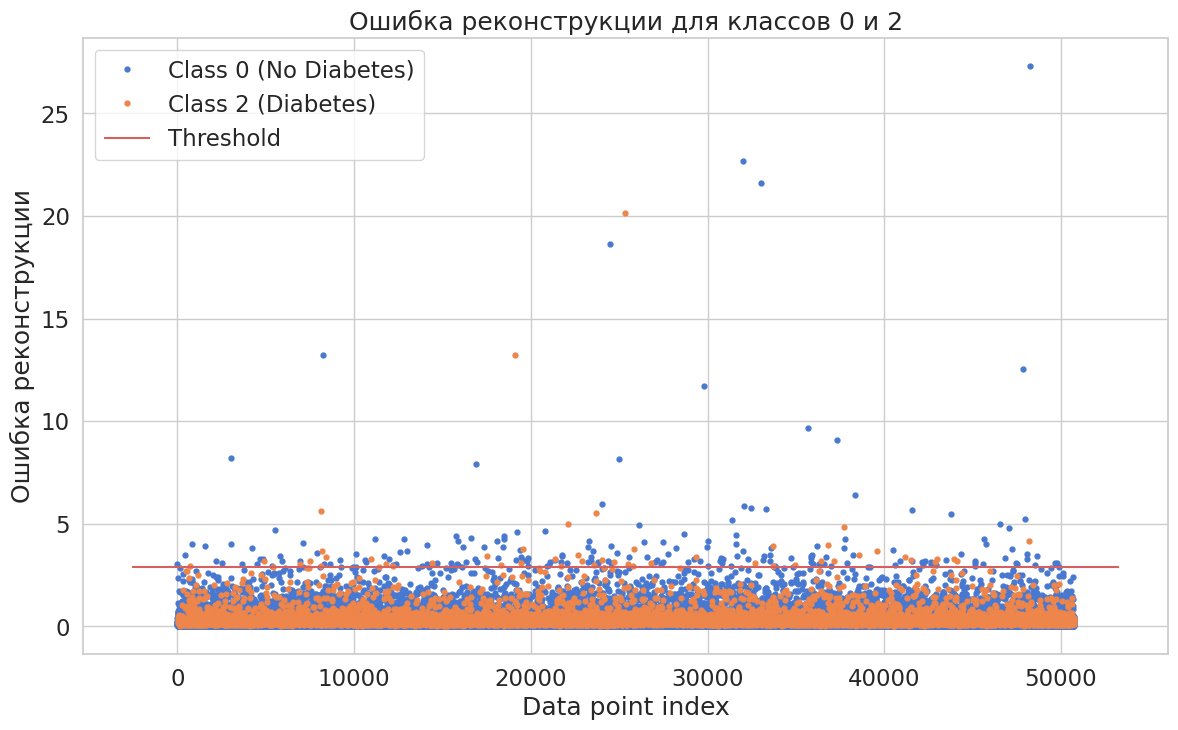

In [60]:
# Группировка данных по бинарным меткам
groups = filtered_df.groupby('binary_labels')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label="Class 2 (Diabetes)" if name == 1 else "Class 0 (No Diabetes)")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для классов 0 и 2")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show()

Построим и посмотрим confusion matrix:

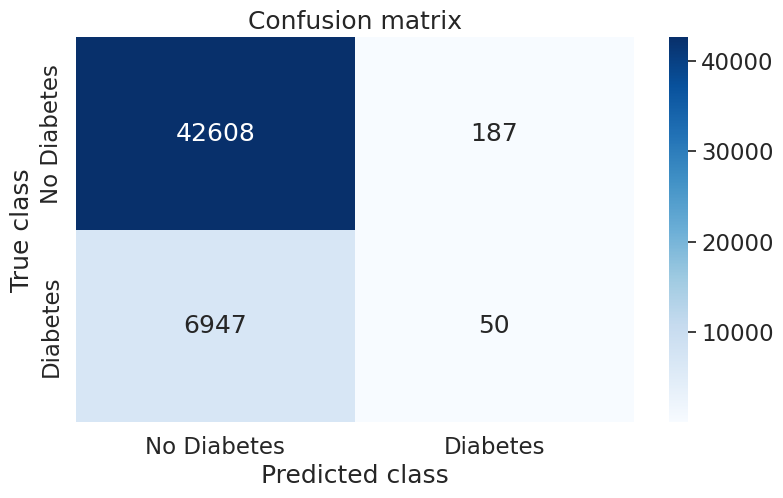

In [64]:
# Предсказания на основе порога
y_pred = [1 if e > threshold else 0 for e in filtered_df.pred_loss.values]

# Матрица ошибок
conf_matrix = confusion_matrix(filtered_df['binary_labels'], y_pred)

# Отображение матрицы ошибок
plt.figure(figsize=(9, 5))
sns.heatmap(conf_matrix, xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"],
            annot=True, fmt="d", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Наша модель, похоже, выявляет множество случаев мошенничества. Но количество обычных транзакций, классифицируемых как мошенничество, действительно велико. Можно настроить порог здесь и там, чтобы получить лучшие результаты.

## Выводы


Мы создали очень простой Deep Autoencoder в PyTorch, который может реконструировать, как выглядят немошеннические транзакции. Он научился распознавать немошеннические транзакции, изучая некоторые шаблоны, присутствующие в этих транзакциях, и что это за шаблоны, о которых трудно сказать — загадка любой нейронной сети с глубоким обучением.

PyTorch предоставил нам очень понятный и простой в использовании API для создания нетривиального Deep Autoencoder. Можно попытаться создать аналогичный автоэнкодер, используя другую структуру, например Tensorflow/Keras/fast.ai, для другого домена/проблемы, например, классифицировать изображения как содержащие неприемлемый контент.